# Wallstreetbets data (Kaggle) EDA

### Parent Directory Configurations 

**Notebook note:** Please make sure that the `PATH` of this notebook corresponds to the base-directory path of this repository. 
This will ensure that all executions, data reading will have the reference as if this notebook were in the base directory; 
otherwise, you might need to change the PATH and do some trickery (which is a pain for Jupyter notebooks) 

In [3]:
# verify working directory of the notebook 
import os 
print(os.getcwd())

c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP


## Imports 

In [4]:
# General imports
import pprint 
import zipfile 
import logging
import importlib 
from collections import Counter
from typing import Union, List, Tuple, Dict, Any
from tqdm.notebook import tqdm 

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

# NLTK setup
import nltk 
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Text Processing 
import re 
import spacy
import gensim
from gensim import corpora
from emoji import demojize
from spacy.tokens import Doc
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim.models.callbacks import PerplexityMetric
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS

# Dedicated NLP Visualizations 
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud

# Custom scripts 
from src.topic_modelling import format_topics_sentences
from src.topic_modelling import plot_topic_keywords

# Configurations 
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Exclude common negation words from the stop words list
# negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", 'none', 'through'}
except_words = {'through'}
stop_words = stop_words - except_words

# Load Spacy model and disable irrelevant components for acceleration
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])
# nlp.max_length = 1500000  # Adjust based on your text size

# Set pprint options with indent 4
pprint = pprint.PrettyPrinter(indent=4).pprint

# Ignore warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Notebook parameters 
SAVE_MODEL = False
NUM_TEXTS = 1000

### Extracting the data 

Here, we want to extract and preview the data 

In [5]:
# Specify the path to the zip files
zip_file_path = 'data_raw/reddit_wsb.csv.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_raw')

# Read the CSV using Pandas
csv_file_path = 'data_raw/reddit_wsb.csv'
df = pd.read_csv(csv_file_path)

# Fill all the NaN values in the body column with an empty string
df['body'] = df['body'].fillna('')

# Combine the title and bodyy into a single column text, separated by two newlines
df['text'] = df['title'] + '\n\n' + df['body']

# drop the body column 
df = df.drop(columns=['body'])

# Preview the loaded data 
display(df.head(40))

,title,score,id,url,comms_num,created,timestamp,text
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,2021-01-28 21:37:41,"It's not about the money, it's about sending a..."
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,2021-01-28 21:30:35,Exit the system\n\nThe CEO of NASDAQ pushed to...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC..."
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,1.611862e+09,2021-01-28 21:26:30,WE BREAKING THROUGH\n\n
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,2021-01-28 21:19:31,THIS IS THE MOMENT\n\nLife isn't fair. My moth...
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1.611862e+09,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...
9,I have nothing to say but BRUH I am speechless...,291,l6uas9,https://i.redd.it/bfzzw2yo42e61.jpg,27,1.611862e+09,2021-01-28 21:18:37,I have nothing to say but BRUH I am speechless...


In [6]:
print(df.shape)
print(df.columns)

(53187, 8)
Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'timestamp',
       'text'],
      dtype='object')


In [7]:
texts = df['text'].iloc[0:10, ].tolist()
texts

["It's not about the money, it's about sending a message. 🚀💎🙌\n\n",
 'Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts\n\n',
 'Exit the system\n\nThe CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)\n\nNow SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”\n\nWe may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down w

### Text Cleaning (for Clustering)

In [9]:
# Import the necessary libraries 
from src.text_preprocessor import clean_lda_text 

# Extract all the titles from the dataframe
texts = df['text'].tolist()[:NUM_TEXTS]

# Clean the corpus
clean_texts = clean_lda_text(texts, clean_emojis=True, verbose=True)

Cleaning Texts:   0%|          | 0/1000 [00:00<?, ?it/s]

Creating trigrams...: 100%|██████████| 1000/1000 [00:00<00:00, 28365.96it/s]


In [10]:
# Display the cleaned corpus
for i, document in enumerate(clean_texts): 
    if i < 20: 
        print("original doc: \t", texts[i])
        print("clean doc: \t", document)
    else: 
        break

original doc: 	 It's not about the money, it's about sending a message. 🚀💎🙌


clean doc: 	 ['money', 'message']
original doc: 	 Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts


clean doc: 	 ['math', 'professor', 'scott', 'steiner', 'number', 'disaster', 'gamestop', 'short']
original doc: 	 Exit the system

The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go

# LDA Modelisation 



## Model training 

In [24]:
# Import the necessary libraries
from src.topic_modelling import train_lda_model 

# Create a dictionary with the parameters used in the LDA model 
lda_params = {
    'num_topics': 4,                 # The number of requested latent topics to be extracted from the training corpus
    'update_every': 1,               # Number of documents to be iteratively updated
    'chunksize': 100,                 # Number of documents to be used in each training chunk
    'passes': 7,                     # Number of passes through the corpus during training
    'alpha': 'symmetric',            # Hyperparameter affecting sparsity/thickness of the topics
    'iterations': 100,               # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
}

# Train the LDA model
lda_model, corpus, id2word = train_lda_model(clean_texts, lda_params=lda_params)

# Display the topics
pprint(lda_model.print_topics())

[   (   0,
        '0.032*"robinhood" + 0.021*"gme" + 0.016*"xb" + 0.015*"account" + '
        '0.015*"stock" + 0.015*"app" + 0.011*"fucking" + 0.010*"wsb" + '
        '0.009*"right" + 0.009*"fuck"'),
    (   1,
        '0.032*"gme" + 0.029*"robinhood" + 0.027*"stock" + 0.016*"company" + '
        '0.015*"share" + 0.014*"nok" + 0.013*"amc" + 0.011*"gme_amc" + '
        '0.010*"today" + 0.010*"moon"'),
    (   2,
        '0.024*"gme" + 0.018*"people" + 0.017*"share" + 0.014*"robinhood" + '
        '0.011*"sec" + 0.009*"thing" + 0.008*"stock" + 0.008*"time" + '
        '0.007*"cnbc" + 0.006*"game"'),
    (   3,
        '0.018*"short" + 0.015*"gme" + 0.014*"stock" + 0.012*"market" + '
        '0.012*"time" + 0.010*"money" + 0.010*"like" + 0.009*"day" + '
        '0.008*"position" + 0.007*"gamestop"')]


## Model Loading 

In [13]:
# # Load function from src 
# from src.topic_modelling import load_lda_model

# # Example usage
# model_dir = "models/lda_model"
# lda_model, id2word = load_lda_model(model_dir)


### Top N topic words

In [25]:
# Reload topic_modelling module
import src.topic_modelling
importlib.reload(src.topic_modelling)

# Load the function from src
from src.topic_modelling import extract_top_words

# Extract top 10 words per topic
top_words_dict = extract_top_words(lda_model, top_n=40)

# Print the top n words for each topic by contactenating them with comas 
for topic_id, top_words in top_words_dict.items():
    print(f"Topic {topic_id}: {', '.join(top_words)}")


Topic 0: robinhood, gme, xb, account, stock, app, fucking, wsb, right, fuck, guy, like, rh, sub, edit, broker, hold, fidelity, point, friday, money, early, time, line, shit, community, mod, financial_advice, transfer, message, close, cash, platform, war, information, real, tendie, retard, review, twitter
Topic 1: gme, robinhood, stock, company, share, nok, amc, gme_amc, today, moon, webull, meme, new, position, hedge_fund, price, money, trade, short, rh, long, morning, people, option, good, buy, right, float, fuck, year, trading, hard, current, bb, play, dillard, like, worth, million, high
Topic 2: gme, people, share, robinhood, sec, thing, stock, time, cnbc, game, post, price, fundamental, market, day, order, today, hedge_fund, money, amc, guy, power, big, option, literally, long, nok_amc, possible, moment, shit, new, float, investor, life, like, rocket, short, man, ability, future
Topic 3: short, gme, stock, market, time, money, like, day, position, gamestop, price, people, week, bro

### Topic Names

**TODO:** These names should be decided by a LLM?

In [26]:
candidate_topic_names = [
    "Stock Market Analysis",
    "Investment Strategies",
    "Financial Growth and Valuation",
    "Corporate Earnings and Revenue",
    "Market Trends and Predictions",
    "Social Media Trading",
    "Retail Investor Sentiment",
    "GameStop and Meme Stocks",
    "Online Trading Platforms",
    "Market Disruptions by Retail Investors",
    "Technological Advancements",
    "Emerging Industries",
    "Product Innovation",
    "Market Disruption",
    "Strategic Partnerships and Contracts",
    "Stock Trading Strategies",
    "Market Volatility",
    "Short Selling and Squeezes",
    "Options Trading",
    "Market Liquidity and Volume"
]

# transform into topic_names dictionary with index as key
topic_names = {i: name for i, name in enumerate(candidate_topic_names)} 

## Assign Cluster to Text 

In [27]:

def assign_topic(raw_text: str, lda_model: LdaModel, return_all: bool = False, verbose: bool = False) -> Union[Tuple[int, float], List[Tuple[int, float]]]:
    """
    Assigns a topic to a given raw text using an LDA model.

    Args:
        raw_text (str): The raw text to assign a topic to.
        lda_model (LdaModel): The trained LDA model.
        return_all (bool, optional): Whether to return all topics and their probabilities. Defaults to False.
        verbose (bool, optional): Whether to print the original and cleaned text. Defaults to False.

    Returns:
        Union[Tuple[int, float], List[Tuple[int, float]]]: The most likely topic and its probability, or a list of all topics and their probabilities.
    """
    # Preprocess the raw text
    cleaned_text = clean_lda_text([raw_text], clean_emojis=True, verbose=False)[0]

    # Show text before and after cleaning
    if verbose:
        print(f"Original text: {raw_text}")
        print(f"Cleaned text: {' '.join(cleaned_text)}")

    # Convert the cleaned text into bag-of-words format
    bow = lda_model.id2word.doc2bow(cleaned_text)
    
    # Get the topic distribution for the text
    topic_distribution = lda_model.get_document_topics(bow)
    
    # Sort the topic distribution by probabilities in descending order
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    
    return sorted_topics if return_all else sorted_topics[0]


In [28]:
# try the function with one sample text 
sample_text = df['text'].iloc[0]

# Assign the topic to the sample text
sample_topic = assign_topic(sample_text, lda_model)
print(sample_topic)

(0, 0.7358878)


In [29]:
def create_topics_df(texts: List[str], lda_model: LdaModel) -> pd.DataFrame:
    """
    Assign topics to a list of texts and create a dataframe with the assigned topics.

    Parameters:
        texts: A list of text documents.
        lda_model (LdaModel): The trained LDA model.

    Returns:
        A pandas DataFrame with the assigned topics for each text document.
    """

    # Assign topics to the texts
    assigned_topics = [assign_topic(doc, lda_model, return_all=True) for doc in texts]

    # Create a list of records using list comprehensions
    records = [{
        'doc_text': doc_text,
        'most_likely_topic': topics_i[0][0],
        'probability': topics_i[0][1],
        'topics': [tup[0] for tup in topics_i]
    } for doc_text, topics_i in zip(df['text'].iloc[:10], assigned_topics)]

    # Create a dataframe from the records
    df_assigned_topics = pd.DataFrame(records)
    
    return df_assigned_topics


In [30]:
# Assign topics to the texts
df_assigned_topics = create_topics_df(df['text'].iloc[:10], lda_model)
df_assigned_topics

,doc_text,most_likely_topic,probability,topics
0,"It's not about the money, it's about sending a...",0,0.735731,"[0, 3, 1, 2]"
1,Math Professor Scott Steiner says the numbers ...,3,0.915748,"[3, 2, 1, 0]"
2,Exit the system\n\nThe CEO of NASDAQ pushed to...,2,0.306051,"[2, 3, 1, 0]"
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,1,0.713928,"[1, 2, 0, 3]"
4,"Not to distract from GME, just thought our AMC...",0,0.559665,"[0, 1, 2, 3]"
5,WE BREAKING THROUGH\n\n,0,0.250000,"[0, 1, 2, 3]"
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...,0,0.452602,"[0, 1, 3, 2]"
7,THIS IS THE MOMENT\n\nLife isn't fair. My moth...,2,0.991838,[2]
8,Currently Holding AMC and NOK - Is it retarded...,1,0.891730,"[1, 2, 0, 3]"
9,I have nothing to say but BRUH I am speechless...,1,0.812238,"[1, 0, 2, 3]"


## Dominant Topic and Percentage Contribution in each Document

In [31]:
# Apply the function to the LDA model, corpus, and original texts to get the topic distribution DataFrame
df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_texts)

# Display the first 10 rows of the DataFrame
df_dominant_topic.head(10)

iterating through corpus...: 100%|██████████| 1000/1000 [00:00<00:00, 2951.52it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8458,"gme, robinhood, stock, company, share, nok, am...","[money, message]"
1,1,3,0.7289,"short, gme, stock, market, time, money, like, ...","[math, professor, scott, steiner, number, disa..."
2,2,2,0.5055,"gme, people, share, robinhood, sec, thing, sto...","[system, ceo, nasdaq, trading, investor, chanc..."
3,3,2,0.5706,"gme, people, share, robinhood, sec, thing, sto...","[new, sec, filing, gme, retarded, interpret]"
4,4,1,0.9297,"gme, robinhood, stock, company, share, nok, am...","[gme_amc, brother, aware]"
5,5,1,0.8724,"gme, robinhood, stock, company, share, nok, am...",[]
6,6,2,0.8008,"gme, people, share, robinhood, sec, thing, sto...","[short, stock, doesnt, expiration, date, hedge..."
7,7,2,0.8074,"gme, people, share, robinhood, sec, thing, sto...","[moment, life, fair, mother, arbitrary, treatm..."
8,8,1,0.7905,"gme, robinhood, stock, company, share, nok, am...","[currently, amc_nok, retarded, gme, today]"
9,9,3,0.7500,"short, gme, stock, market, time, money, like, ...","[bruh, speechless, moon]"


## The most representative sentence for each topic

In [32]:
# Increase the maximum width of columns in pandas DataFrame displays to show more characters
pd.options.display.max_colwidth = 100

# Initialize an empty DataFrame to store sorted topic information
sent_topics_sorteddf_mallet = pd.DataFrame()

# Group the DataFrame by the 'Dominant_Topic' column
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

# Iterate over each group representing a single dominant topic
for i, grp in sent_topics_outdf_grpd:
    # Sort the grouped DataFrame by 'Perc_Contribution' in descending order and take the first row
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)],
                                            axis=0)

# Reset the index of the sorted DataFrame to be continuous and start from 0
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.drop(columns=["Document_No"])

# Assign column names to the sorted DataFrame for better readability
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Display the first 10 rows of the sorted DataFrame to show the most representative text for each topic
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9945,"robinhood, gme, xb, account, stock, app, fucking, wsb, right, fuck",[autists]
1,1,0.9916,"gme, robinhood, stock, company, share, nok, amc, gme_amc, today, moon","[alternate, play, atos, share, bout, call, recently, boy]"
2,2,0.9977,"gme, people, share, robinhood, sec, thing, stock, time, cnbc, game","[rh, ability, stock, different, stock, sndl, babyyyyy, rn, lets, gooo]"
3,3,0.9968,"short, gme, stock, market, time, money, like, day, position, gamestop","[personal, scare_tactic, total, opposite, effect, opportunity, gme, trade, future, obsessed, mon..."


## Word Clouds of Top N Keywords in Each Topic

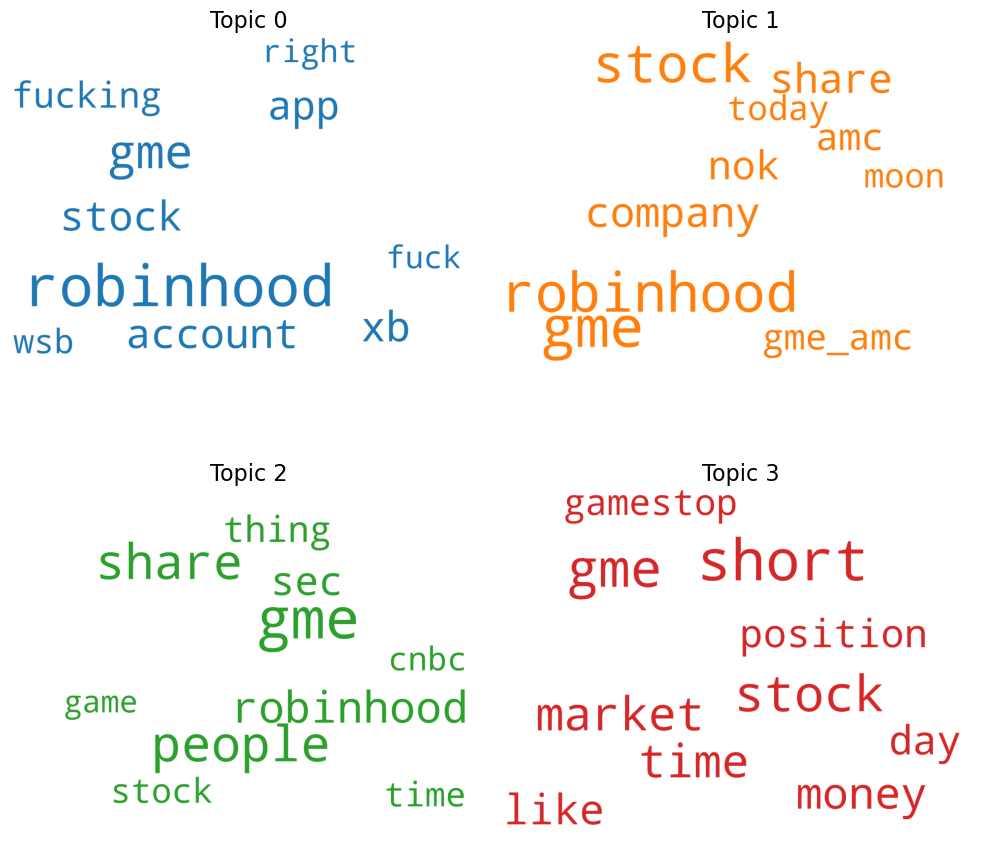

In [33]:
# Extracting a list of colors from the TABLEAU_COLORS dictionary
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# Creating a WordCloud object with specified parameters
cloud = WordCloud(stopwords=stop_words,  # Providing stopwords for the WordCloud
                  background_color='white',  # Setting background color to white
                  width=2500,  # Setting width of the WordCloud
                  height=1800,  # Setting height of the WordCloud
                  max_words=30,  # Limiting maximum number of words in the WordCloud
                  colormap='tab10',  # Setting colormap for colors
                  color_func=lambda *args, **kwargs: cols[i],  # Setting custom color function for the WordCloud
                  prefer_horizontal=1.0)  # Setting horizontal preference for word orientation

# Extracting topics from lda_model and formatting them
topics = lda_model.show_topics(formatted=False)

# Creating a subplot grid for displaying multiple WordClouds
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# Iterating over each subplot and displaying WordCloud for each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extracting words for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generating WordCloud from word frequencies
    plt.gca().imshow(cloud)  # Displaying WordCloud on current axis
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))  # Setting title for the WordCloud
    plt.gca().axis('off')  # Turning off axis for cleaner visualization

# Adjusting spacing between subplots and removing unnecessary axis
plt.subplots_adjust(wspace=0, hspace=0)  # Adjusting spacing between subplots
plt.axis('off')  # Turning off axis for the entire figure
plt.margins(x=0, y=0)  # Setting margins to zero for tighter layout
plt.tight_layout()  # Adjusting layout for better visualization
plt.show()  # Displaying the entire plot

## Word Counts of Topic Keywords

In [34]:
def plot_topic_keywords(lda_model, clean_texts):

    # Extract topics and flatten data
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in clean_texts for w in w_list]
    counter = Counter(data_flat)

    # Initialize empty list to store data
    out = []

    # Iterate over topics and their words to retrieve the weights and
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    # Create DataFrame from collected data
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)

    # Define colors for each subplot
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    # Iterate over subplots
    for i, ax in enumerate(axes.flatten()):
        # Plot bar chart for word count
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')

        # Create twinx axis for importance
        ax_twin = ax.twinx()

        # Plot bar chart for word importance
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')

        # Set y-axis labels
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.050)
        ax.set_ylim(0, 10000)

        # Set title for subplot
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)

        # Hide y-axis ticks
        ax.tick_params(axis='y', left=False)

        # Rotate x-axis labels
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

        # Add legends
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout(w_pad=2)
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

    # Show plot
    plt.show()

    return df

C:\Users\jairp\AppData\Local\Temp\ipykernel_15624\3156908514.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\jairp\AppData\Local\Temp\ipykernel_15624\3156908514.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\jairp\AppData\Local\Temp\ipykernel_15624\3156908514.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\jairp\AppData\Local\Temp\ipykernel_15624\3156908514.py:48: UserWarning: set_ticklabels() should only be used with a

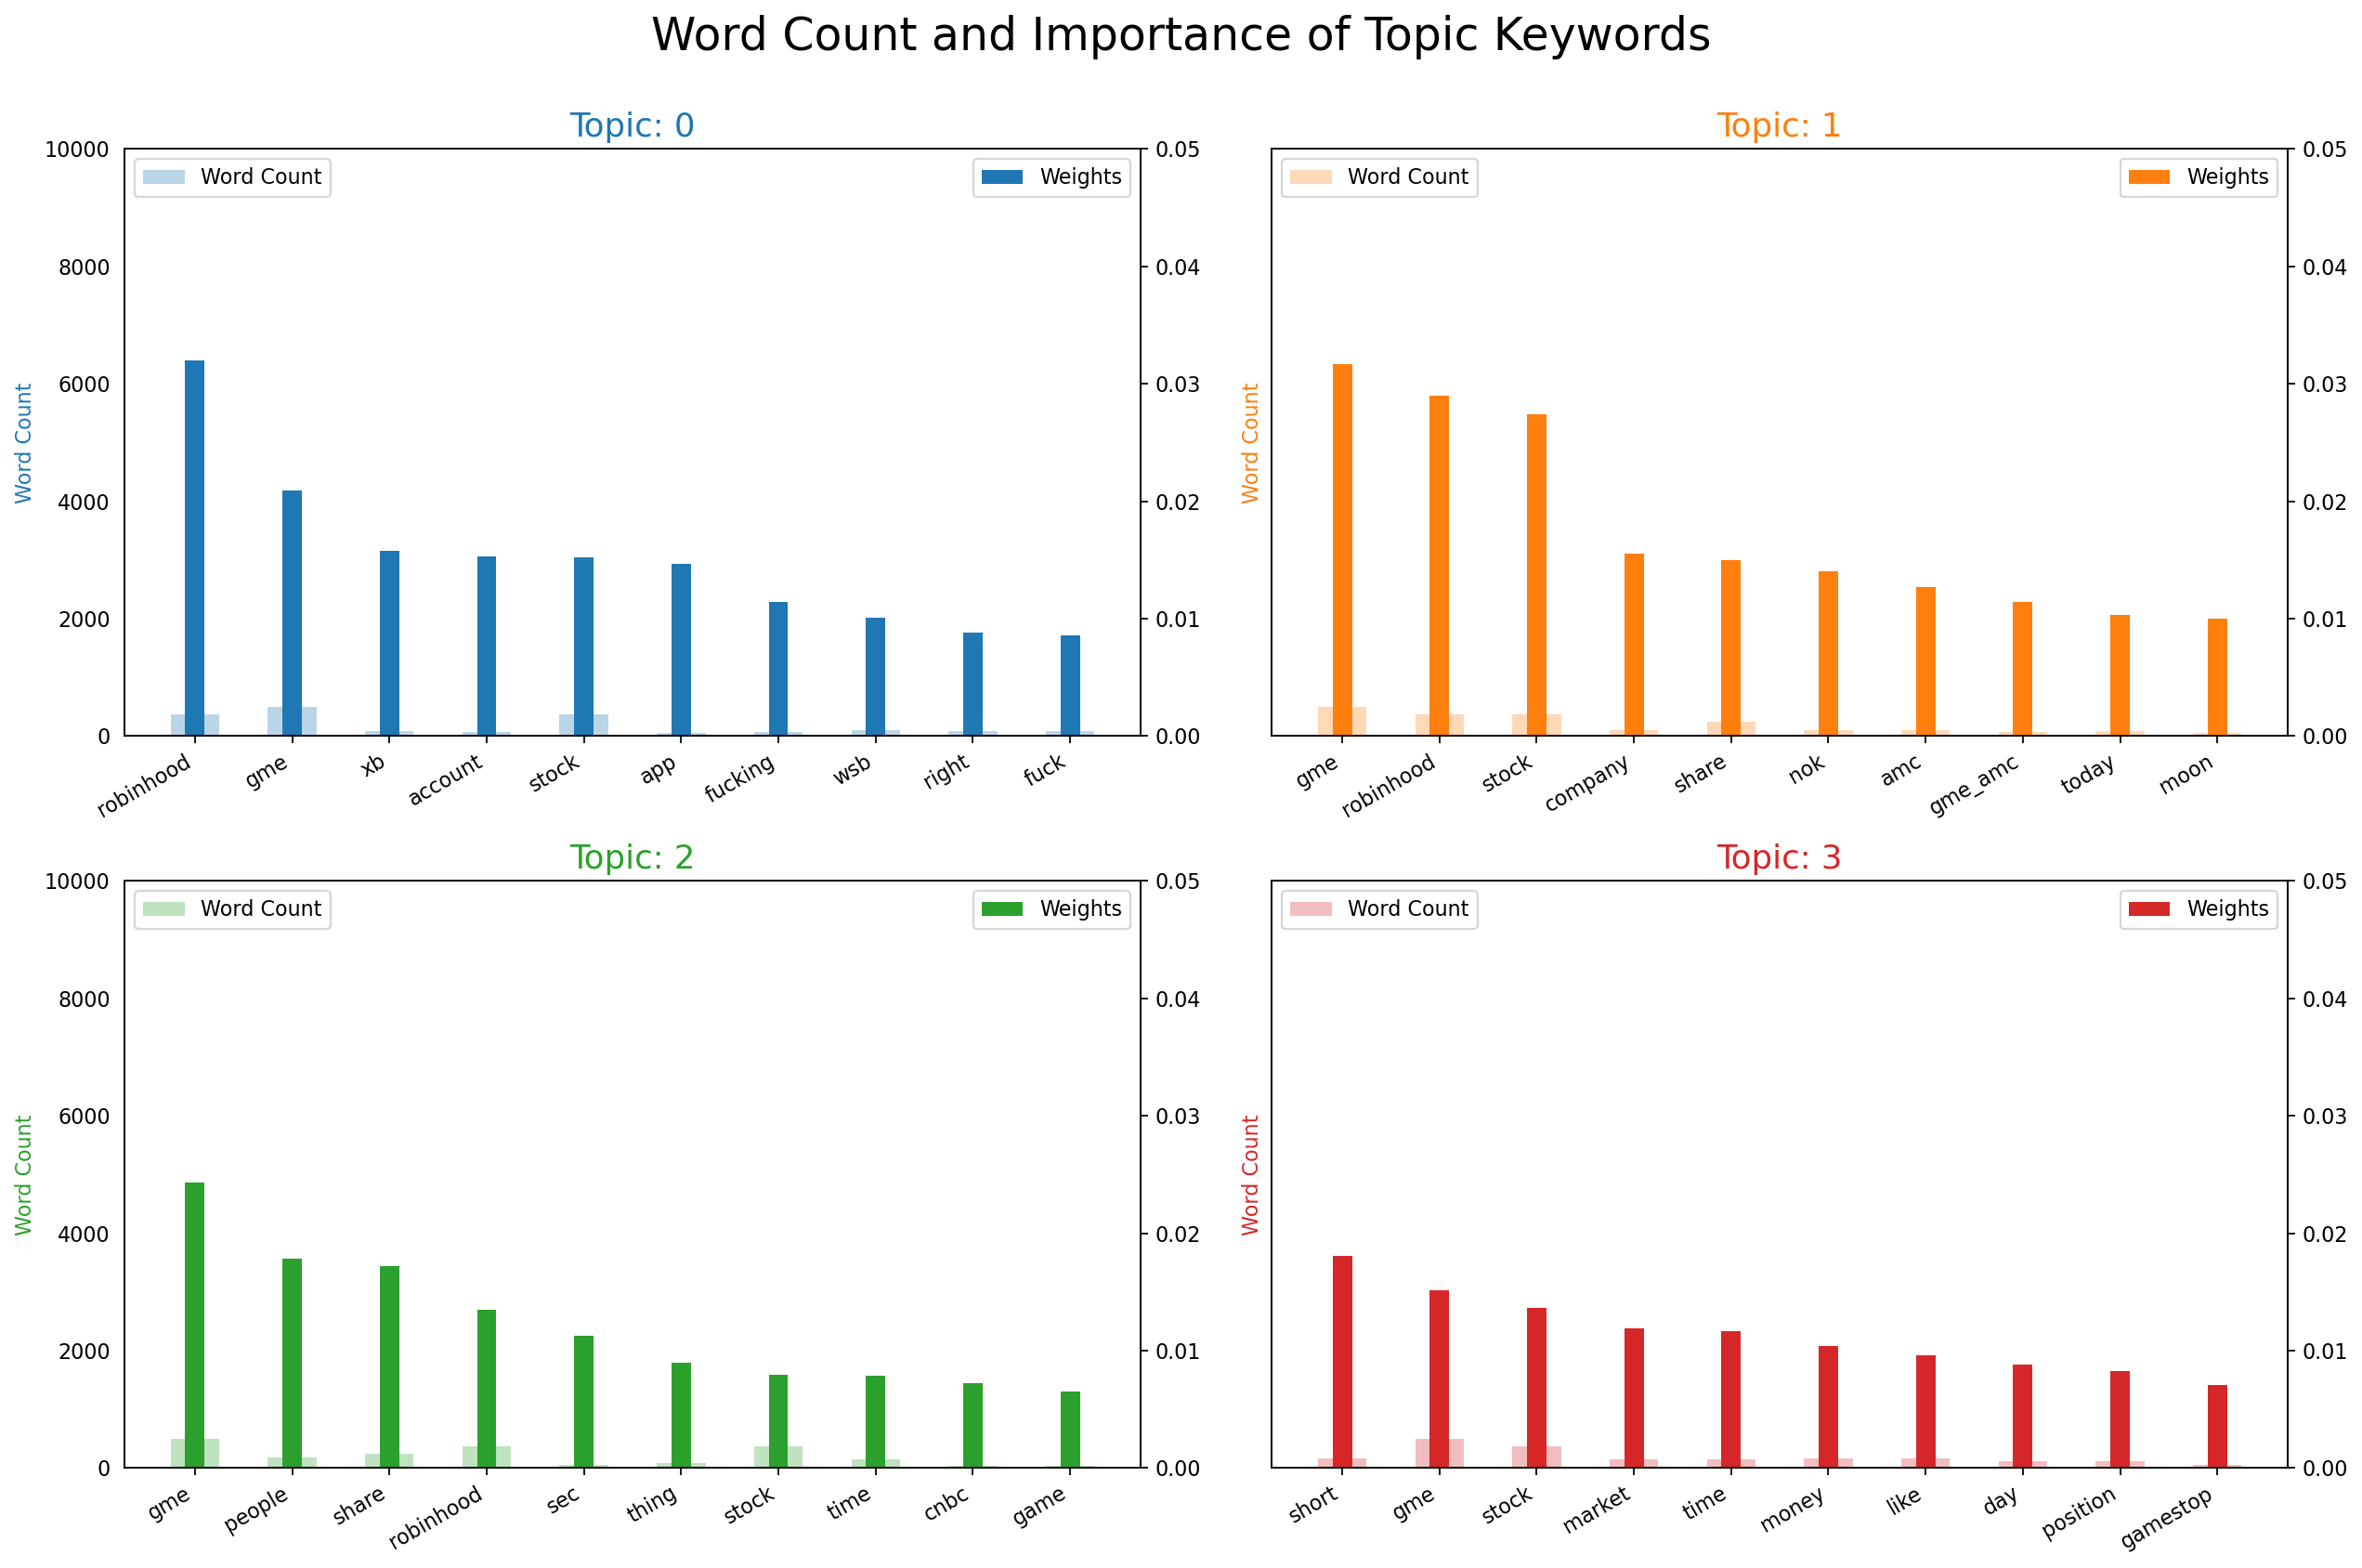

In [35]:
word_topic_distr = plot_topic_keywords(lda_model, clean_texts)

In [36]:
word_topic_distr.shape

(40, 4)

### Top Words per Topic df

In [37]:
def create_top_words_dictionary(df, by_weights=True, top_n=20):
    top_words_dict = {}
    
    # Group the dataframe by topic_id
    grouped = df.groupby('topic_id')
    
    for topic_id, group in grouped:
        # Sort the group by either 'importance' (weights) or 'word_count'
        if by_weights:
            sorted_group = group.sort_values(by='importance', ascending=False)
        else:
            sorted_group = group.sort_values(by='word_count', ascending=False)
        
        # Get the top n words for the topic
        top_words = sorted_group.head(top_n)['word'].tolist()
        
        # Add the top words to the dictionary
        top_words_dict[topic_id] = top_words
    
    return top_words_dict


In [38]:
# Assuming your DataFrame is named word_topic_distr
top_words_dict = create_top_words_dictionary(word_topic_distr, by_weights=True, top_n=50)
pprint(top_words_dict)


{   0: [   'robinhood',
           'gme',
           'xb',
           'account',
           'stock',
           'app',
           'fucking',
           'wsb',
           'right',
           'fuck'],
    1: [   'gme',
           'robinhood',
           'stock',
           'company',
           'share',
           'nok',
           'amc',
           'gme_amc',
           'today',
           'moon'],
    2: [   'gme',
           'people',
           'share',
           'robinhood',
           'sec',
           'thing',
           'stock',
           'time',
           'cnbc',
           'game'],
    3: [   'short',
           'gme',
           'stock',
           'market',
           'time',
           'money',
           'like',
           'day',
           'position',
           'gamestop']}


# PCA Distribution of Topics (PyLDAvis)

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.089866  0.195411       1        1  31.801549
2     -0.082095 -0.097405       2        1  23.840410
1     -0.065320 -0.108457       3        1  22.728592
0      0.237281  0.010452       4        1  21.629449, topic_info=          Term        Freq       Total Category  logprob  loglift
1    robinhood  329.000000  329.000000  Default  30.0000  30.0000
436        app   63.000000   63.000000  Default  29.0000  29.0000
0          nok   63.000000   63.000000  Default  28.0000  28.0000
160         xb   80.000000   80.000000  Default  27.0000  27.0000
132    account   78.000000   78.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
2        stock   64.911909  310.624571   Topic4  -4.1853  -0.0344
88        like   35.314997  130.846530   Topic4  -4.7941   0.2214
103       shit   20.976905   63.901065   Topic4  -5.3150   0.4172
94       money   23.372860  140.986045   Topic4  -5.2068  -0.2660
113       time   21.989108  143.078603   Topic4  -5.2678  -0.3417

[269 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
16        2  0.965488      aal
264       2  0.954047  ability
132       1  0.038403  account
132       3  0.128009  account
132       4  0.832056  account
...     ...       ...      ...
160       1  0.161827       xb
160       4  0.834029       xb
404       2  0.328442     year
404       3  0.492663     year
404       4  0.164221     year

[326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])